In [1]:
import torch
import torch.nn as nn
import sys
import copy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from core.util.get_datasets import get_trefor_park_as_tensor
from core.util.io import read_csv
from core.util.get_datasets import denormalize_tensor
from tqdm import tqdm

Set global parameters.

In [2]:
batch_size = 8
learning_rate = 0.0005
EPOCHS = 1
lookback = 24
loss_function = nn.HuberLoss("sum", 0.1)

Read the preprocessed Trefor household data as a timeseries.

In [3]:
training_data = read_csv("processed/park_training.csv")
validation_data = read_csv("processed/park_validation.csv")
testing_data = read_csv("processed/park_testing.csv")
# training_data
# validation_data
# testing_data

Use CUDA (GPU) if available.

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

Split data into a training, validation, and test set. Output of the get_timeserie_dataset are tensors.

In [5]:
x_train, y_train = get_trefor_park_as_tensor(training_data)
x_val, y_val = get_trefor_park_as_tensor(validation_data)
x_test, y_test = get_trefor_park_as_tensor(testing_data)

Create the datasets for train, validation and test.

In [6]:
class TreforData(Dataset):
    """Initialize Trefor dataset."""

    def __init__(self, x: torch.tensor, y: torch.tensor) -> None:
        """Initialize dataset.

        Arguments:
            x: feature as torch
            y: target as torch

        """
        self.x = x.to(device)
        self.y = y.to(device)

    def __len__(self) -> int:
        """Return length of dataset."""
        return len(self.x)

    def __getitem__(self, i: int) -> tuple:
        """Return tuple from dataset."""
        return self.x[i], self.y[i]


train_dataset = TreforData(x_train, y_train)
val_dataset = TreforData(x_val, y_val)
test_dataset = TreforData(x_test, y_test)

Load data into a dataloader with specified batch size from global parameter. Don't shuffle as we use time series were order matters

In [7]:
training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Initialize a very basic LSTM.

In [8]:
class LSTM(nn.Module):
    """Super scuffed LSTM."""

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_stacked_layers: int,
        output_size: int,
    ) -> None:
        """Initialize the LSTM and its layers."""
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(
            input_size, hidden_size, num_stacked_layers, batch_first=True
        )

        # self.fc1 = nn.Linear((input_size * hidden_size), hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.tensor) -> torch.tensor:
        """Define the forward pass."""
        batch_size = x.size(0)

        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(
            device
        )
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(
            device
        )

        x, _ = self.lstm(x, (h0, c0))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x[:, -1, :])

        return x


model = LSTM(input_size=1, hidden_size=15, num_stacked_layers=5, output_size=24)
model.to(device)
# model

LSTM(
  (lstm): LSTM(1, 15, num_layers=5, batch_first=True)
  (fc1): Linear(in_features=15, out_features=15, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=15, out_features=24, bias=True)
)

Function for training one epoch.

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
plot_train_loss = []
plot_val_loss = []


def train_one_epoch() -> float:
    """Train one epoch."""
    running_loss = 0.0
    last_loss = 0.0

    for i, data in enumerate(training_loader):
        # Every data instance is an input + target
        inputs, target = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        predictions = model(inputs)
        target = target.squeeze(-1)

        # Compute the loss and its gradients
        loss = loss_function(predictions, target)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100  # loss per 100 batch
            # print(f'  batch {i+1} loss: {last_loss}')
            running_loss = 0.0
    return last_loss

Validate the training model on the validation set for each epoch.

In [10]:
epoch_number = 0
best_v_loss = sys.maxsize
best_model = None


for epoch in tqdm(range(EPOCHS)):
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch()

    running_v_loss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, v_data in enumerate(validation_loader):
            v_inputs, v_target = v_data
            v_predictions = model(v_inputs)
            v_target = v_target.squeeze(-1)
            v_loss = loss_function(v_predictions, v_target)
            running_v_loss += v_loss.item()

    avg_v_loss = running_v_loss / (i + 1)

    # Log the running loss averaged per batch
    # for both training and validation
    # print(f'Training : {avg_loss}, Validation : {avg_v_loss}')
    plot_train_loss.append(avg_loss)
    plot_val_loss.append(avg_v_loss)

    # Track best performance, and save the model's state
    if avg_v_loss < best_v_loss:
        best_v_loss = avg_v_loss
        best_model = copy.deepcopy(model)

    epoch_number += 1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.18s/it]


Evaluate the final model on the test data.

In [11]:
best_model.eval()
predicted = []
t_loss = 0
num_batches = len(testing_loader)
size = len(testing_loader.dataset)
with torch.no_grad():
    for i, t_data in enumerate(testing_loader):
        t_inputs, t_target = t_data
        t_predictions = best_model(t_inputs)
        predicted.append(t_predictions)
        t_target = t_target.squeeze(-1)  # Ensure dimensions match
        t_loss += loss_function(t_predictions, t_target).item()

predicted = torch.cat(predicted, dim=0)
t_loss /= num_batches
print(f"Avg loss: {t_loss:>8f} \n")

Avg loss: 2.532523 



Visualize the training and validation loss.

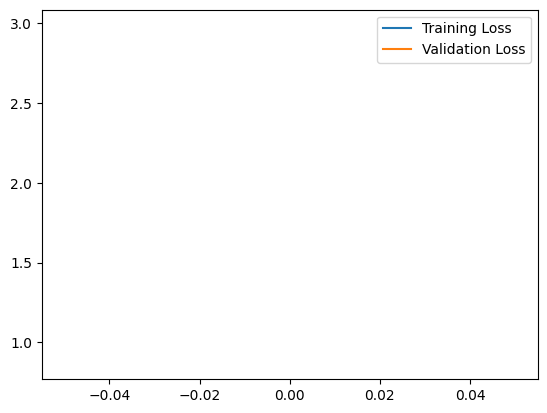

In [12]:
plt.clf()
plt.plot(plot_train_loss, label="Training Loss")
plt.plot(plot_val_loss, label="Validation Loss")
plt.legend()
plt.show()

Visualize model performance. Actual consumption plotted with the predicted consumption.

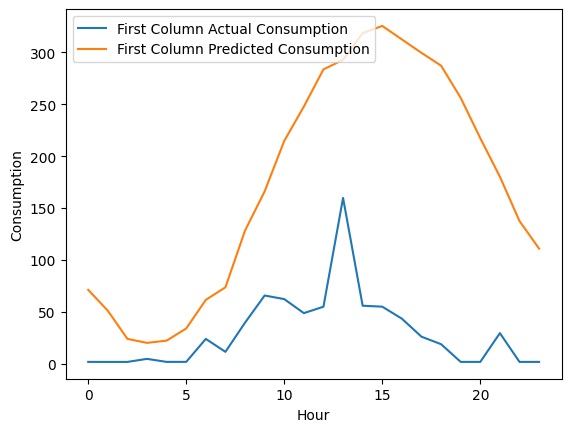

In [13]:
y_test = denormalize_tensor(y_test, 700)
predicted = denormalize_tensor(predicted, 700)
first_column_actual = y_test[-1].flatten()
first_column_predicted = predicted[-1].flatten()
plt.plot(first_column_actual, label="First Column Actual Consumption")
plt.plot(first_column_predicted, label="First Column Predicted Consumption")
plt.xlabel("Hour")
plt.ylabel("Consumption")
plt.legend()
plt.show()